The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
오늘 날짜 : 2022-01-17
cuda device : cuda:2
x_train.size() =  torch.Size([100, 1, 28, 28]) 	type torch.FloatTensor
y_train.size() =  torch.Size([100]) 	type torch.LongTensor


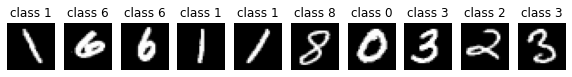

In [122]:
%load_ext autoreload
%autoreload 2

from my_utils import *
from my_models import *
from config import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import datetime


batch_size = 100

device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
today = datetime.date.today()
print('오늘 날짜 :',today)
print('cuda device :', device)

train_dataset, test_dataset, train_loader, test_loader = load_MNIST()

pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))
for x_train, y_train in train_loader:
    print('x_train.size() = ',x_train.size(), '\ttype', x_train.type())
    print('y_train.size() = ', y_train.size(), '\ttype', y_train.type())
    break

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(x_train[i,:,:,:].permute(1,2,0), cmap="gray")
    plt.title('class '+ str(y_train[i].item()))

In [123]:
import os 
from torchvision.utils import save_image
import shutil

def split_data_into_folder(path = 'data/MNIST/classes/'):
    
    for i in range(0,10):
        shutil.rmtree(path + '{}'.format(i))
        os.mkdir(path + '{}'.format(i))

    for label_index in range(10):
        final_index = 0
        for batch_idx, (image, label) in enumerate(train_loader):
            for idx in range(len(label)):
                if label[idx] == label_index:
                    save_image(image[idx], path + '{}/{}_{}.png'.format(label[idx], label[idx],final_index))
                    final_index += 1
                else:
                    pass
    for i in range(10):
        print(len(os.listdir(path + '{}'.format(i))))

# split_data_into_folder()

In [124]:
# PATH = 'data/MNIST/classes'
# cls = 7

# for i in range(len(os.listdir(PATH + '/{}'.format(cls)))):
#     if i <= int(len(os.listdir(PATH + '/{}'.format(cls))) * 0.8):
#         shutil.move(PATH + '/binary/{}/{}_{}.png'.format(cls,cls,i),
#                     PATH + '/binary/train/{}/{}_{}.png'.format(cls,cls,i))
#     else:
#         shutil.move(PATH + '/binary/{}/{}_{}.png'.format(cls,cls,i),
#                     PATH + '/binary/test/{}/{}_{}.png'.format(cls,cls,i))


image.size() =  torch.Size([100, 1, 28, 28]) 	type torch.FloatTensor
label.size() =  torch.Size([100]) 	type torch.LongTensor


<Figure size 720x72 with 0 Axes>

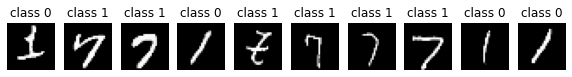

In [125]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

train_data = ImageFolder('data/MNIST/classes/binary/train', 
                         transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.5),   # 3 for RGB channels이나 실제론 gray scale
                                                                                std=(0.5))])) 
test_data = ImageFolder('data/MNIST/classes/binary/test', 
                         transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.5),   # 3 for RGB channels이나 실제론 gray scale
                                                                                std=(0.5))])) 

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))
for image, label in train_loader:
    print('image.size() = ',image.size(), '\ttype', image.type())
    print('label.size() = ', label.size(), '\ttype', label.type())
    break

plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(image[i,:,:,:].permute(1,2,0), cmap="gray")
    plt.title('class '+ str(label[i].item()))

In [126]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(ResidualBlock, self).__init__()

        #nn.Conv2d(input channel, output channel, ...)
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size = 3,
                               stride=stride,
                               padding=1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(planes) # Batchnorm은 사이의 가중치가 아니라 출력 층만 노말라이징
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size = 3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size = 1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(planes))
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, rgb = 3, num_classes = 10):
        super(ResNet, self).__init__()

        self.rgb = rgb
        self.in_planes = 16
        # RGB여서 3, in_planes는 내맘대로 16
        self.conv1 = nn.Conv2d(self.rgb,16,
                               kernel_size = 3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64,2)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] *(num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_planes,planes,stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out1 = F.relu(self.bn1(self.conv1(x)))
        out2 = self.layer1(out1)
        out3 = self.layer2(out2)
        out4 = self.layer3(out3)
        out5 = F.avg_pool2d(out4, 7)
        out6 = out5.view(out5.size(0), -1)
        out7 = self.linear(out6)
        
        return out7

In [127]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)


        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval ==0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))
    return output

def evaluate(model, test_loader):
    model.eval()
    test_loss=0
    correct=0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # output에서 제일 큰 놈의 index를 반환한다(이경우에 0 or 1)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100*correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [128]:
# model = ResNet(rgb = 1, num_classes=2).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# criterion = nn.CrossEntropyLoss()
# best_accuracy = 0
# for Epoch in range(1, 10+1):
#     train(model, train_loader, optimizer, log_interval=200)
#     test_loss, test_accuracy = evaluate(model, test_loader)
#     if test_accuracy > best_accuracy:
#         best_accuracy = test_accuracy
#         torch.save(model, 'pretrained_model/ResNet_1_7.pt')
#         torch.save(model.state_dict(), 'pretrained_model/ResNet_parameters_1_7.pt')
#     print("[EPOCH: {}], \tTest Loss: {:.4f},\tTest Accuracy: {:.2f}%\n".format(
#         Epoch, test_loss, test_accuracy))

In [66]:
class Explainer(nn.Module):
    def __init__(self, num_latent, num_code, num_classes = 10):
        super(Explainer, self).__init__()
        
        self.input_dim = self.num_latent
        
        self.num_classes = num_classes
        self.num_latent = num_latent
        self.num_code = num_code # classifier에 하나, 
        self.conceptizer = nn.Sequential(nn.Linear(64*7*7, self.num_latent), nn.ReLU())
        self.dim_adjust = nn.Linear(self.num_latent, 64*7*7)
        
        self.classifier = nn.Sequential(nn.Linear(self.num_code, 128),nn.ReLU(),
                                        nn.Linear(128,128),nn.ReLU(),
                                        nn.Linear(128,64),nn.ReLU(),
                                        nn.Linear(64,num_classes))
        
        self.generator = nn.Sequential(nn.ConvTranspose2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                                    nn.ReLU(), nn.BatchNorm2d(128),
                                    nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                                    nn.ReLU(), nn.BatchNorm2d(64),
                                    nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
                                    nn.ReLU(), nn.BatchNorm2d(32),
                                    nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1))
    
    def conceptize(self,encoded):
        # 펼쳐진 것을 저차원으로 매핑
        flattened = encoded.view(-1,64*7*7)
        conceptized = self.conceptizer(flattened)
        return conceptized
        
    def predict(self, conceptized):
        # 원하는 갯수의 concept정보를 갖고 클래스를 예측
        cls_concept = conceptized[:,:self.num_code]
        predicted = self.classifier(cls_concept)
        return predicted

    def generate(self, conceptized):
        # conceptized 된 정보 전체로 이미지 복원
        blocked = self.dim_adjust(conceptized).view(-1,64,7,7)
        generated = self.generater(blocked)
        return generated
    
    def forward(self,encoded):
        concept = self.conceptize(encoded)
        predicted = self.predict(concept)
        generated = self.generate(concept)
        
        return concept, predicted, generated
        

In [67]:
def train(model, train_loader, optimizer, alpha, Epoch):
    model.train()
    for param in model[0].parameters():
        param.requires_grad = False
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        target = image.to(device)
        optimizer.zero_grad()
        _, predicted, decoded= model(image)
        loss_G = alpha*criterion_G(decoded, target)
        loss_P = (1-alpha)*criterion_P(predicted, label)
        loss =  loss_G + loss_P 
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss(G+P): {:.5f} = {:.5f} + {:.5f}".format(
                Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), 
                loss_G+loss_P, loss_G.item(), loss_P.item()))

In [68]:
temp_model = ResNet(rgb=1, num_classes=2).to(device)
temp_model.load_state_dict(torch.load('pretrained_model/ResNet_parameters_1_7.pt'))
encoder = nn.Sequential(*(list(temp_model.children())[:5])).to(device)
explainer = Explainer(64,4,2).to(device)

model = nn.Sequential(encoder, explainer).to(device)
optimizer_P = torch.optim.Adam(explainer.parameters(), lr=0.001)
optimizer_G = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE, betas = )
optimizer_D = 

predicted_loss = nn.CrossEntropyLoss()
adversarial_loss = nn.MSELoss()
discrete_loss = nn.CrossEntropyLoss()
continuous_loss = nn.MSELoss()

alpha = 0.8

for Epoch in range(1, 20+1):
    train(model, train_loader, optimizer, alpha, Epoch)

Train Epoch: 1 [0/10407(0%)]	Train Loss(G+P): 3.23717 = 3.10243 + 0.13474
Train Epoch: 1 [10000/10407(95%)]	Train Loss(G+P): 0.13592 = 0.13570 + 0.00022
Train Epoch: 2 [0/10407(0%)]	Train Loss(G+P): 0.13062 = 0.13044 + 0.00018
Train Epoch: 2 [10000/10407(95%)]	Train Loss(G+P): 0.08739 = 0.08717 + 0.00022
Train Epoch: 3 [0/10407(0%)]	Train Loss(G+P): 0.08853 = 0.08831 + 0.00022
Train Epoch: 3 [10000/10407(95%)]	Train Loss(G+P): 0.07390 = 0.07379 + 0.00011
Train Epoch: 4 [0/10407(0%)]	Train Loss(G+P): 0.08493 = 0.08468 + 0.00024
Train Epoch: 4 [10000/10407(95%)]	Train Loss(G+P): 0.08055 = 0.07411 + 0.00645
Train Epoch: 5 [0/10407(0%)]	Train Loss(G+P): 0.06664 = 0.06647 + 0.00017
Train Epoch: 5 [10000/10407(95%)]	Train Loss(G+P): 0.06365 = 0.06343 + 0.00022
Train Epoch: 6 [0/10407(0%)]	Train Loss(G+P): 0.06980 = 0.06553 + 0.00426
Train Epoch: 6 [10000/10407(95%)]	Train Loss(G+P): 0.05310 = 0.05295 + 0.00015
Train Epoch: 7 [0/10407(0%)]	Train Loss(G+P): 0.06116 = 0.06102 + 0.00014
Train Ep

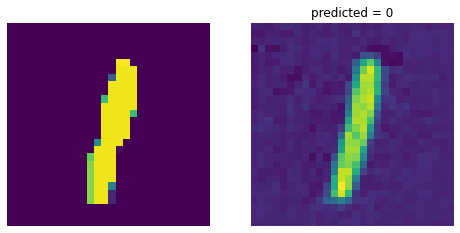

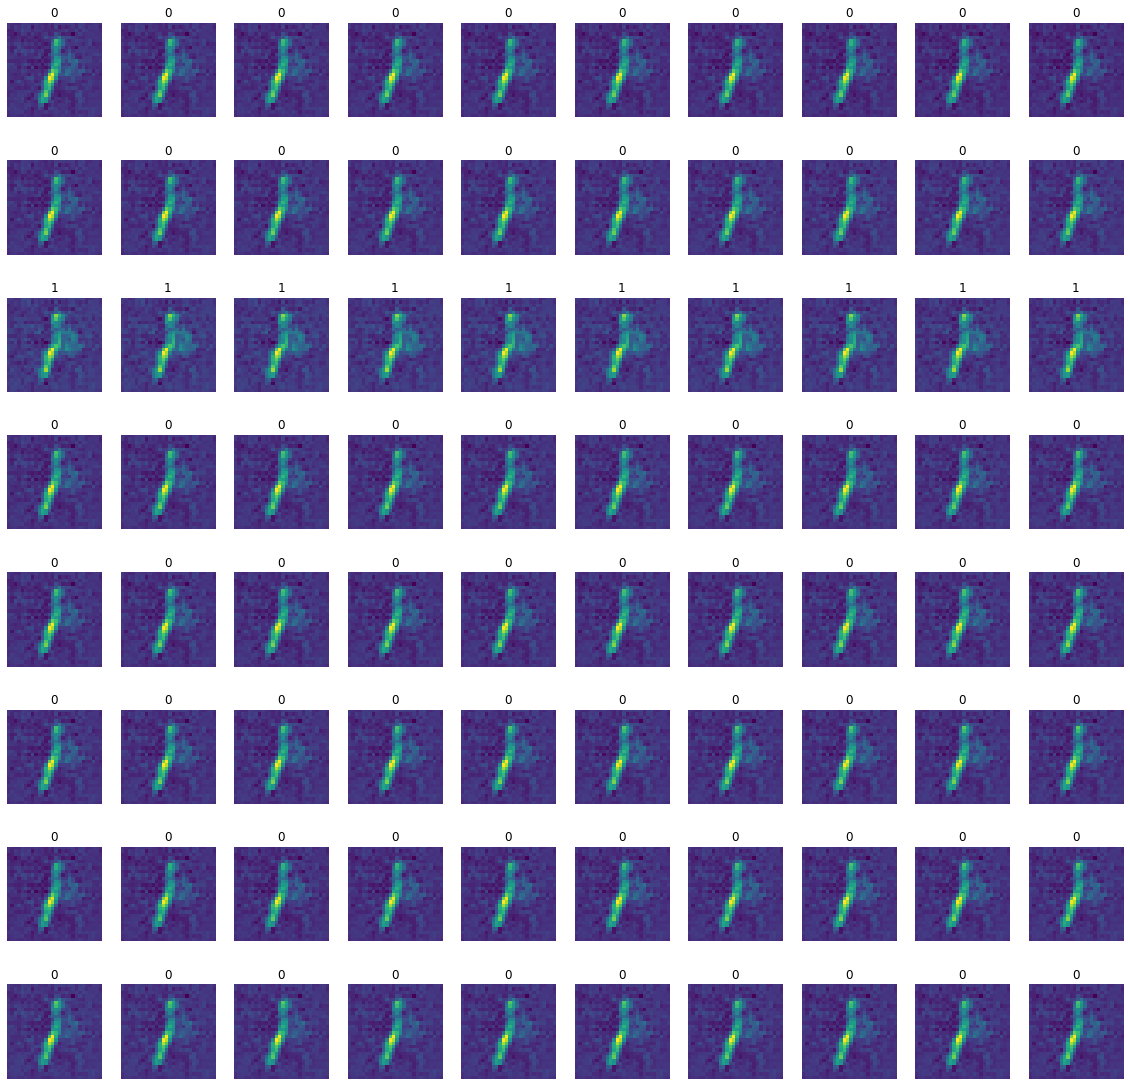

In [69]:
def min_max_scaling(data):
    min_ = np.min(data)
    max_ = np.max(data-min_)
    return (data-min_)/max_

for img, _ in test_loader:
    image = img.to(device)
    conceptized, predicted, decoded = model(image)
    break

batch_idx = 10
# embedded = embedded.view(-1,64*7*7)

predicted_class1 = np.argmax(predicted[batch_idx].cpu().detach().numpy())

pltsize=8
plt.figure(figsize=(pltsize,pltsize))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image[batch_idx].permute(1,2,0).cpu().detach().numpy())

plt.subplot(1,2,2)
plt.axis('off')
plt.title('predicted = {}'.format(predicted_class1))
plt.imshow(min_max_scaling(decoded[batch_idx].permute(1,2,0).cpu().detach().numpy()))

pltsize=20
plt.figure(figsize=(pltsize,2*pltsize))
for i in range(8):
    embedded_1 = model[1].conceptize(encoder(image[15].unsqueeze(0)))
    embedded_2 = model[1].conceptize(encoder(image[i+1].unsqueeze(0)))
    for j in range(10):
        # embedded = embedded_1**0.1 + embedded_2*(1-j*0.1)
        embedded_1[:,i:i+1] = 0.3*j # 0~4 분류에 중요 4~8 분류에 안중요
        predicted_class2 = np.argmax(model[1].predict(embedded_1)[0].cpu().detach().numpy())
        plt.subplot(16,10,10*i+j+1)
        plt.axis('off')
        plt.title('{}'.format(predicted_class2))
        my_img = model[1].decode(embedded_1)[0].permute(1,2,0).cpu().detach().numpy()
        plt.imshow(min_max_scaling(my_img))

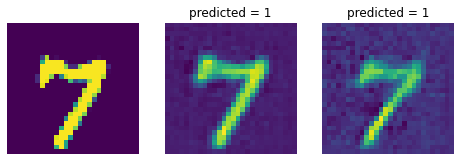

In [70]:
batch_idx = 7
# embedded = embedded.view(-1,64*7*7)

predicted_class1 = np.argmax(predicted[batch_idx].cpu().detach().numpy())

pltsize=8
plt.figure(figsize=(pltsize,pltsize))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(image[batch_idx].permute(1,2,0).cpu().detach().numpy())

plt.subplot(1,3,2)
plt.axis('off')
plt.title('predicted = {}'.format(predicted_class1))
plt.imshow(min_max_scaling(decoded[batch_idx].permute(1,2,0).cpu().detach().numpy()))

plt.subplot(1,3,3)
plt.axis('off')
plt.title('predicted = {}'.format(predicted_class1))
encoded = model[1].conceptize(encoder(image[batch_idx].unsqueeze(0)))
plt.imshow(min_max_scaling(explainer.decode(encoded)[0].permute(1,2,0).cpu().detach().numpy()))

In [72]:
torch.max(encoded)

tensor(14.4259, device='cuda:2', grad_fn=<MaxBackward1>)